In [9]:
import numpy as np
import networkx as nx

from qiskit import Aer
from qiskit.algorithms import NumPyMinimumEigensolver

In [41]:
num_nodes = 4
w = np.array([[0., 1., 1., 0.],
              [1., 0., 1., 1.],
              [1., 1., 0., 1.],
              [0., 1., 1., 0.]])
G = nx.from_numpy_matrix(w)

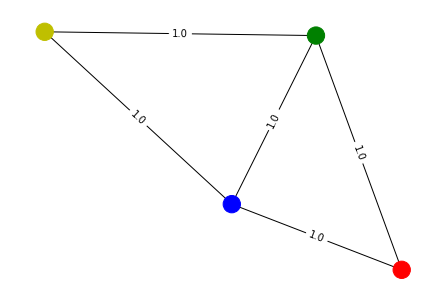

In [50]:
layout = nx.random_layout(G, seed=10)
colors = ['r', 'g', 'b', 'y']
nx.draw(G, layout, node_color=colors)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels);

In [43]:
def objective_value(x, w):
    X = np.outer(x, (1 - x))
    w_01 = np.where(w != 0, 1, 0)
    return np.sum(w_01 * X)

def brute_force():
    # use the brute-force way to generate the oracle
    def bitfield(n, L):
        result = np.binary_repr(n, L)
        return [int(digit) for digit in result]  # [2:] to chop off the "0b" part

    L = num_nodes
    max = 2**L
    minimal_v = np.inf
    for i in range(max):
        cur = bitfield(i, L)

        how_many_nonzero = np.count_nonzero(cur)
        if how_many_nonzero * 2 != L:  # not balanced
            continue

        cur_v = objective_value(np.array(cur), w)
        if cur_v < minimal_v:
            minimal_v = cur_v
    return minimal_v

sol = brute_force()
print(f'Objective value computed by the brute-force method is {sol}')

Objective value computed by the brute-force method is 3


In [44]:
from qiskit.quantum_info import Pauli
from qiskit.opflow import PauliSumOp

def get_operator(weight_matrix):
    r"""Generate Hamiltonian for the graph partitioning
    Notes:
        Goals:
            1 separate the vertices into two set of the same size
            2 make sure the number of edges between the two set is minimized.
        Hamiltonian:
            H = H_A + H_B
            H_A = sum\_{(i,j)\in E}{(1-ZiZj)/2}
            H_B = (sum_{i}{Zi})^2 = sum_{i}{Zi^2}+sum_{i!=j}{ZiZj}
            H_A is for achieving goal 2 and H_B is for achieving goal 1.
    Args:
        weight_matrix (numpy.ndarray) : adjacency matrix.
    Returns:
        PauliSumOp: operator for the Hamiltonian
        float: a constant shift for the obj function.
    """
    num_nodes = len(weight_matrix)
    pauli_list = []
    shift = 0

    for i in range(num_nodes):
        for j in range(i):
            if weight_matrix[i, j] != 0:
                x_p = np.zeros(num_nodes, dtype=bool)
                z_p = np.zeros(num_nodes, dtype=bool)
                z_p[i] = True
                z_p[j] = True
                pauli_list.append([-0.5, Pauli((z_p, x_p))])
                shift += 0.5

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                x_p = np.zeros(num_nodes, dtype=bool)
                z_p = np.zeros(num_nodes, dtype=bool)
                z_p[i] = True
                z_p[j] = True
                pauli_list.append([1, Pauli((z_p, x_p))])
            else:
                shift += 1

    pauli_list = [(pauli[1].to_label(), pauli[0]) for pauli in pauli_list]
    return PauliSumOp.from_list(pauli_list), shift

qubit_op, offset = get_operator(w)

In [45]:
from collections import OrderedDict
from qiskit.utils import algorithm_globals
from qiskit.algorithms import QAOA
from qiskit.opflow import StateFn
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal

def sample_most_likely(state_vector):
    """Compute the most likely binary string from state vector.
    Args:
        state_vector (numpy.ndarray or dict): state vector or counts.
    Returns:
        numpy.ndarray: binary string as numpy.ndarray of ints.
    """
    if isinstance(state_vector, (OrderedDict, dict)):
        # get the binary string with the largest count
        binary_string = sorted(state_vector.items(), key=lambda kv: kv[1])[-1][0]
        x = np.asarray([int(y) for y in reversed(list(binary_string))])
        return x
    elif isinstance(state_vector, StateFn):
        binary_string = list(state_vector.sample().keys())[0]
        x = np.asarray([int(y) for y in reversed(list(binary_string))])
        return x
    else:
        n = int(np.log2(state_vector.shape[0]))
        k = np.argmax(np.abs(state_vector))
        x = np.zeros(n)
        for i in range(n):
            x[i] = k % 2
            k >>= 1
        return x

def objective_value(x, w):
    """Compute the value of a cut.
    Args:
        x (numpy.ndarray): binary string as numpy array.
        w (numpy.ndarray): adjacency matrix.
    Returns:
        float: value of the cut.
    """
    X = np.outer(x, (1 - x))
    w_01 = np.where(w != 0, 1, 0)
    return np.sum(w_01 * X)

algorithm_globals.random_seed = 10598

optimizer = COBYLA()
qaoa = QAOA(optimizer, quantum_instance=Aer.get_backend('statevector_simulator'))

result = qaoa.compute_minimum_eigenvalue(qubit_op)

x = sample_most_likely(result.eigenstate)

print(x)
print(f'Objective value computed by QAOA is {objective_value(x, w)}')

[0. 1. 1. 0.]
Objective value computed by QAOA is 4.0


In [46]:
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(qubit_op)

x = sample_most_likely(result.eigenstate)

print(x)
print(f'Objective value computed by the NumPyMinimumEigensolver is {objective_value(x, w)}')

[1 1 0 0]
Objective value computed by the NumPyMinimumEigensolver is 3


In [47]:
from qiskit.algorithms import VQE
from qiskit.circuit.library import TwoLocal

algorithm_globals.random_seed = 10598

optimizer = COBYLA()
ansatz = TwoLocal(qubit_op.num_qubits, 'ry', 'cz', reps=5, entanglement='linear')
vqe = VQE(ansatz, optimizer, quantum_instance=Aer.get_backend('statevector_simulator'))

result = vqe.compute_minimum_eigenvalue(qubit_op)

x = sample_most_likely(result.eigenstate)

print(x)
print(f'Objective value computed by VQE is {objective_value(x, w)}')

[0. 1. 0. 1.]
Objective value computed by VQE is 3.0
